In [167]:
import matplotlib.pyplot as plt

In [168]:
import PIL

In [169]:
import numpy as np

In [170]:
import tensorflow as tf

In [171]:
from tensorflow.keras import layers

In [172]:
from tensorflow.keras.models import Sequential

In [173]:
import os

In [174]:
import pathlib

In [175]:
data_dir = "/Users/wisdom/Documents/masked-faced-dataset"
data_dir = pathlib.Path(data_dir)

In [207]:
image_count = len(list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.jpg')))

In [208]:
print(image_count)

1638


/Users/wisdom/Documents/masked-faced-dataset/masked/cloth-18.jpeg


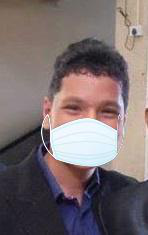

In [244]:
masked = list(data_dir.glob('masked/*'))
print(str(masked[456]))
PIL.Image.open(str(masked[13]))

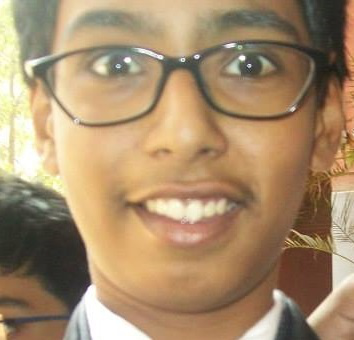

In [242]:
not_masked = list(data_dir.glob('not_masked/*.jpg')) + list(data_dir.glob('not_masked/*.jpeg'))
PIL.Image.open(str(not_masked[13]))

In [180]:
batch_size = 32
img_height = 180
img_width = 180

In [181]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)

In [182]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"]))
print(class_names)

['masked' 'not_masked']


In [183]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [184]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

1326
327


In [185]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1650 files belonging to 2 classes.
Using 1320 files for training.


In [186]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1650 files belonging to 2 classes.
Using 330 files for validation.


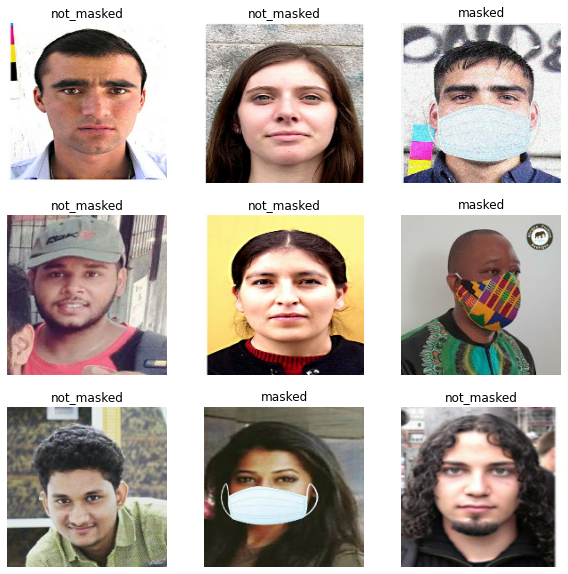

In [187]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [188]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [189]:
AUTOTUNE = tf.data.AUTOTUNE

In [190]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [191]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [192]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [193]:
num_classes = 2
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [194]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [195]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

In [196]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = epochs
)

Epoch 1/10
42/42 [==============================] - 15s 347ms/step - loss: 0.8995 - accuracy: 0.5169 - val_loss: 0.3233 - val_accuracy: 0.8848
Epoch 2/10
42/42 [==============================] - 13s 310ms/step - loss: 0.3121 - accuracy: 0.8806 - val_loss: 0.1527 - val_accuracy: 0.9515
Epoch 3/10
42/42 [==============================] - 13s 306ms/step - loss: 0.1700 - accuracy: 0.9411 - val_loss: 0.1350 - val_accuracy: 0.9576
Epoch 4/10
42/42 [==============================] - 13s 315ms/step - loss: 0.1555 - accuracy: 0.9352 - val_loss: 0.1338 - val_accuracy: 0.9606
Epoch 5/10
42/42 [==============================] - 13s 305ms/step - loss: 0.1155 - accuracy: 0.9559 - val_loss: 0.1547 - val_accuracy: 0.9394
Epoch 6/10
42/42 [==============================] - 13s 311ms/step - loss: 0.1035 - accuracy: 0.9668 - val_loss: 0.1468 - val_accuracy: 0.9364
Epoch 7/10
42/42 [==============================] - 13s 305ms/step - loss: 0.0915 - accuracy: 0.9691 - val_loss: 0.1699 - val_accuracy: 0.9333

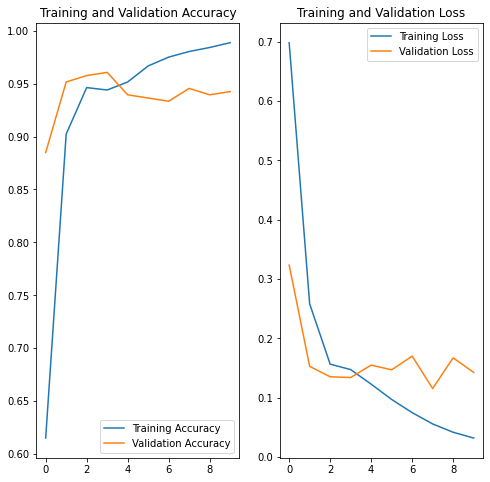

In [197]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [200]:
sunflower_path = '/Users/wisdom/Downloads/masked-png.jpg'

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to not_masked with a 63.05 percent confidence.


In [206]:
sunflower_url = 'https://cdn.shopify.com/s/files/1/0257/9152/8994/products/20200416_184756_2_800x.jpg?v=1587430098'
sunflower_path = tf.keras.utils.get_file('not_m_3', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

204800/202188 [==============================] - 0s 1us/step
This image most likely belongs to masked with a 100.00 percent confidence.


In [245]:
model.save('/Users/wisdom/Downloads')

INFO:tensorflow:Assets written to: /Users/wisdom/Downloads/assets
